In [ ]:
from google.colab import drive
drive.mount("/content/drive") 

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('/content/drive/MyDrive/FIRE/train.csv')


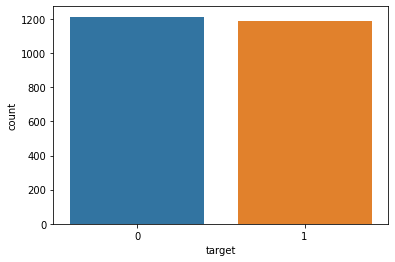

In [ ]:
import seaborn as sns
sns.countplot(x='target', data=df) 

In [ ]:
import copy
clean_tweets = copy.deepcopy(df[["tweet"]])

In [ ]:
!pip install Urduhack[tf-gpu]

     |████████████████████████████████| 105 kB 5.4 MB/s 
     |████████████████████████████████| 3.4 MB 37.7 MB/s 
     |████████████████████████████████| 458.3 MB 11 kB/s 
     |████████████████████████████████| 1.1 MB 29.4 MB/s 
  Attempting uninstall: tensorflow-datasets
    Found existing installation: tensorflow-datasets 4.0.1
    Uninstalling tensorflow-datasets-4.0.1:
      Successfully uninstalled tensorflow-datasets-4.0.1


In [ ]:
from urduhack import normalize
from tqdm import tqdm
tqdm.pandas(desc="Normalizing Data...")
clean_tweets['tweet'] = clean_tweets['tweet'].progress_apply(normalize)

Normalizing Data...: 100%|██████████| 2400/2400 [00:00<00:00, 65596.22it/s]


In [ ]:
train_tweets = clean_tweets['tweet'].tolist()
train_labels = df['target'].tolist()

In [ ]:
# from sklearn.model_selection import train_test_split
# train_tweets, val_tweets, train_labels, val_labels = train_test_split(raw_tweets, raw_labels, test_size=0.2)

In [ ]:
pip install "ray[tune]" transformers datasets

     |████████████████████████████████| 49.6 MB 6.2 kB/s 
     |████████████████████████████████| 2.6 MB 35.4 MB/s 
     |████████████████████████████████| 264 kB 48.5 MB/s 
     |████████████████████████████████| 3.3 MB 37.1 MB/s 
     |████████████████████████████████| 636 kB 41.5 MB/s 
     |████████████████████████████████| 895 kB 41.7 MB/s 
     |████████████████████████████████| 118 kB 54.6 MB/s 
     |████████████████████████████████| 243 kB 47.4 MB/s 
     |████████████████████████████████| 72 kB 542 kB/s 
     |████████████████████████████████| 124 kB 51.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer 
checkpoint = "urduhack/roberta-urdu-small" 
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

Downloading:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/516 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.61M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.15M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [ ]:
train_encodings = tokenizer(train_tweets, truncation=True, padding=True)


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
import torch

class tweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = tweetDataset(train_encodings, train_labels)
# val_dataset = tweetDataset(val_encodings, val_labels)

In [ ]:
from transformers import Trainer, TrainingArguments


In [ ]:
import numpy as np
from datasets import load_metric
from sklearn.metrics import f1_score,confusion_matrix,accuracy_score,roc_auc_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    # precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    # acc = accuracy_score(labels, preds)
    f1=f1_score(labels, preds,average='weighted')
    roc=roc_auc_score(val_labels,pred.predictions[:,1])
    return {
        'f1': f1
    }

def model_init():
    return AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

In [ ]:
training_args = TrainingArguments(
    "train")
trainer = Trainer(
    args=training_args,
    train_dataset=train_dataset,
    # eval_dataset=val_dataset,
    model_init=model_init,
    # compute_metrics=compute_metrics,
)
setattr(trainer.args, 'learning_rate', 4.439102767051409e-05)
setattr(trainer.args, 'num_train_epochs' ,2)
setattr(trainer.args, 'per_device_train_batch_size' , 4)
setattr(trainer.args, 'evaluation_strategy' , 'epoch')

trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/urduhack/roberta-urdu-small/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/291698f9be37d779927f29078aa9b50a3f22793aa3e1d4677e3fc32ed66cc372.d06f17ba960b226631a106100ff93f3a815ca0811ee5a7b01cfced77781791ad
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
 

Step,Training Loss,Validation Loss


Saving model checkpoint to train/checkpoint-500
Configuration saved in train/checkpoint-500/config.json
Model weights saved in train/checkpoint-500/pytorch_model.bin
Saving model checkpoint to train/checkpoint-1000
Configuration saved in train/checkpoint-1000/config.json
Model weights saved in train/checkpoint-1000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1200, training_loss=0.48227634429931643, metrics={'train_runtime': 242.3833, 'train_samples_per_second': 19.803, 'train_steps_per_second': 4.951, 'total_flos': 123333307200000.0, 'train_loss': 0.48227634429931643, 'epoch': 2.0})

# Test


In [ ]:
df_test=pd.read_csv('/content/drive/MyDrive/FIRE/test.csv')

In [ ]:
df_test['tweet'] = df_test['tweet'].progress_apply(normalize)
test_tweets=df_test['tweet'].tolist()
ids=df_test['id']

Normalizing Data...: 100%|██████████| 1100/1100 [00:00<00:00, 27691.49it/s]


In [ ]:
test_encodings = tokenizer(test_tweets, truncation=True, padding=True)
class testDataset(torch.utils.data.Dataset):
    def __init__(self, encodings,ids):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item

    def __len__(self):
        return 1100
test_dataset = testDataset(test_encodings,ids)


In [ ]:
test_dataset

In [ ]:
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=-1)

***** Running Prediction *****
  Num examples = 1100
  Batch size = 8


In [ ]:
preds

array([0, 1, 0, ..., 0, 1, 0])

In [ ]:
sub_df=df_test['id'].copy()
submission=pd.concat([sub_df,pd.DataFrame(preds)],axis=1)
submission = submission.rename(columns={0:"target"})
submission=pd.concat([submission,pd.DataFrame(predictions.predictions[:,1])],axis=1)
submission = submission.rename(columns={0:"score"})
submission.to_csv('/content/drive/MyDrive/FIRE/Submission1.csv',index=False)